In [21]:
from Bio import SeqIO
from Bio.SeqUtils import GC
import gzip
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns

In [22]:
# Motif predictions
predictions = {}

for chunk in pd.read_csv(
    "./pos_seqs/MA0139.1.tsv.gz", compression="gzip", header=None,
    encoding="utf8", sep="\t", chunksize=1024, comment="#",
    engine="python"
):
    for index, row in chunk.iterrows():
        row = row.tolist()
        predictions.setdefault(row[-1], set())
        predictions[row[-1]].add(row[0])

print(len(predictions["+"]), len(predictions["-"]))

33728 33233


In [26]:
# FASTA sequences
sequences = {}
positive_sequences = {}
negative_sequences = {}
for i in range(101):
    positive_sequences.setdefault(i, [])
with gzip.open("./pos_seqs.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        strands = 0
        region = int(seq_record.id)
        if region in predictions["+"]:
            strands += 1
            sequence = str(seq_record.seq)
        if region in predictions["-"]:
            strands += 1
            sequence = str(seq_record.seq.reverse_complement())
        if strands == 1:
            positive_sequences[round(GC(sequence))].append(region)
            sequences.setdefault(region, sequence)
for i in range(101):
    negative_sequences.setdefault(i, [])
with gzip.open("./neg_seqs.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        region = int(seq_record.id)
        sequence = str(seq_record.seq)
        negative_sequences[round(GC(sequence))].append(region)
        sequences.setdefault(region, sequence)
len(sequences)

136104

In [27]:
# Downsampling
sampled = {}
random_seed = 123
for i in range(101):
    random.Random(random_seed).shuffle(positive_sequences[i])
    random.Random(random_seed).shuffle(negative_sequences[i])
    min_length = min(
        [len(positive_sequences[i]), len(negative_sequences[i])]
    )
    for j in range(min_length):
        sampled.setdefault("positives", set())
        sampled["positives"].add(positive_sequences[i][j])
        sampled.setdefault("negatives", set())
        sampled["negatives"].add(negative_sequences[i][j])
print(len(sampled["positives"]), len(sampled["negatives"]))

57121 57121


In [28]:
# Save sequences
with gzip.open("./pos_seqs.fwd.fa.gz", "wb") as f:
    for positive in sorted(sampled["positives"]):
        string = ">%s\n%s\n" % (positive, sequences[positive])
        f.write(string.encode("utf-8"))
with gzip.open("./neg_seqs.fwd.fa.gz", "wb") as f:
    for negative in sorted(sampled["negatives"]):
        string = ">%s\n%s\n" % (negative, sequences[negative])
        f.write(string.encode("utf-8"))

In [30]:
# Sanity check
gc_positives = []
gc_negatives = []
with gzip.open("./pos_seqs.fwd.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        gc_positives.append(GC(str(seq_record.seq)))
gc_positives = np.array(gc_positives)
with gzip.open("./neg_seqs.fwd.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        gc_negatives.append(GC(str(seq_record.seq)))
gc_negatives = np.array(gc_negatives)
print(len(gc_positives), len(gc_negatives))

57121 57121


In [31]:
# DataFrame
data = []
for i in gc_positives:
    data.append(["positives", i])
for i in gc_negatives:
    data.append(["negatives", i])
df = pd.DataFrame(data, columns=["Sequence", "%GC"])
df

,Sequence,%GC
0,positives,57.0
1,positives,55.0
2,positives,64.0
3,positives,47.5
4,positives,75.0
...,...,...
114237,negatives,42.5
114238,negatives,48.5
114239,negatives,37.5
114240,negatives,50.0


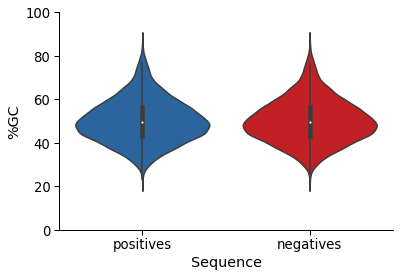

In [32]:
# Plot %GC distributions
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_palette(sns.color_palette(["#1965B0", "#DC050C"]))
g = sns.violinplot(x="Sequence", y="%GC", data=df)
g.set(ylim=(0, 100))
sns.despine()

In [33]:
# Another sanity check
rs_positives = []
rs_negatives = []
for chunk in pd.read_csv(
    "./pos_seqs/MA0139.1.tsv.gz", compression="gzip", header=None,
    encoding="utf8", sep="\t", chunksize=1024, comment="#",
    engine="python"
):
    for index, row in chunk.iterrows():
        row = row.tolist()
        rs_positives.append(row[4])
for chunk in pd.read_csv(
    "./neg_seqs/MA0139.1.tsv.gz", compression="gzip", header=None,
    encoding="utf8", sep="\t", chunksize=1024, comment="#",
    engine="python"
):
    for index, row in chunk.iterrows():
        row = row.tolist()
        rs_negatives.append(row[4])
print(len(rs_positives), len(rs_negatives))

71086 7772


In [35]:
# DataFrame
data = []
for i in rs_positives:
    data.append(["positives", i / 1000.])
for i in rs_negatives:
    data.append(["negatives", i / 1000.])
df = pd.DataFrame(data, columns=["Sequence", "Score"])
df

,Sequence,Score
0,positives,0.921
1,positives,0.868
2,positives,0.831
3,positives,0.816
4,positives,0.876
...,...,...
78853,negatives,0.811
78854,negatives,0.810
78855,negatives,0.838
78856,negatives,0.843


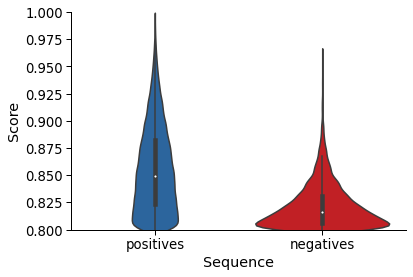

In [36]:
# Plot %GC distributions
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_palette(sns.color_palette(["#1965B0", "#DC050C"]))
g = sns.violinplot(x="Sequence", y="Score", data=df)
g.set(ylim=(0.8, 1.))
sns.despine()